# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
import os.path
from sklearn.model_selection import train_test_split

In [2]:
# diretory of the images
image_dir = Path('./dataset')

# Working on Dataset

In [3]:
# ** means any folder, * means any file with extension .jpg
filepaths = list(image_dir.glob(r'train/*.jpg'))

# Taking the name cat and dog from de images
labels = list(map(lambda x: os.path.split(x)[1][:3],filepaths)) 

# Creating the labels 
filepaths = pd.Series(filepaths, name = 'Filepaths')
labels = pd.Series(labels, name= 'Label')

image_df = pd.concat([filepaths,labels], axis = 1).astype(str)

In [4]:
train_df,  test_df = train_test_split(image_df, train_size = 0.95, shuffle = True,  random_state = 1)

# Load Image Data

In [5]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    validation_split = 0.15
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
)

In [6]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Label',
    target_size=(128,128),
    color_mode='rgba',#rgba
    class_mode='categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'training'
)

validation_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Label',
    target_size=(128,128),
    color_mode='rgba',
    class_mode='categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Label',
    target_size=(128,128),
    color_mode='rgba',
    class_mode='categorical',
    batch_size = 32,
    shuffle = False
)

Found 20188 validated image filenames belonging to 2 classes.
Found 3562 validated image filenames belonging to 2 classes.
Found 1250 validated image filenames belonging to 2 classes.


In [7]:
train_images.class_indices

{'cat': 0, 'dog': 1}

# Training

In [8]:
output_size = 2
hidden_layer_size = 512
inputs = (128,128,4)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (6,6), activation = 'relu', input_shape = inputs),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (5,5), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (4,4), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(4,4)),
    tf.keras.layers.Dropout(0.2),
    
    #tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(output_size, activation='softmax')
])

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    train_images,
    validation_data = validation_images,
    epochs = 14,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = 'val_loss',
            patience = 3
        )
    ]
)

Epoch 1/14
631/631 [==============================] - 1727s 3s/step - loss: 0.7427 - accuracy: 0.6009 - val_loss: 0.6359 - val_accuracy: 0.6294 - lr: 0.0010
Epoch 2/14
631/631 [==============================] - 1706s 3s/step - loss: 0.6080 - accuracy: 0.6691 - val_loss: 0.9662 - val_accuracy: 0.5197 - lr: 0.0010
Epoch 3/14
631/631 [==============================] - 1700s 3s/step - loss: 0.5516 - accuracy: 0.7197 - val_loss: 0.6983 - val_accuracy: 0.5997 - lr: 0.0010
Epoch 4/14
631/631 [==============================] - 1698s 3s/step - loss: 0.5122 - accuracy: 0.7472 - val_loss: 0.6702 - val_accuracy: 0.6005 - lr: 0.0010
Epoch 5/14
631/631 [==============================] - 1700s 3s/step - loss: 0.4469 - accuracy: 0.7882 - val_loss: 0.4326 - val_accuracy: 0.7948 - lr: 1.0000e-04
Epoch 6/14
631/631 [==============================] - 1694s 3s/step - loss: 0.4252 - accuracy: 0.8043 - val_loss: 0.4619 - val_accuracy: 0.7788 - lr: 1.0000e-04
Epoch 7/14
631/631 [==============================

In [9]:
import matplotlib.pyplot as plt

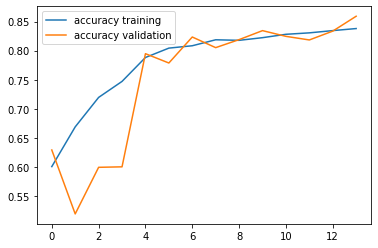

In [10]:
plt.plot(history.history['accuracy'], label = 'accuracy training')
plt.plot(history.history['val_accuracy'], label = 'accuracy validation')
plt.legend()
plt.show()

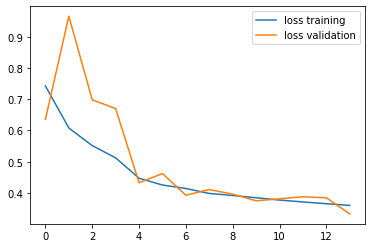

In [11]:
plt.plot(history.history['loss'], label = 'loss training')
plt.plot(history.history['val_loss'], label = 'loss validation')
plt.legend()
plt.show()

In [ ]:
model.save('Conv2D-first')

INFO:tensorflow:Assets written to: Conv2D-first-model\assets
